In [1]:
import os
import time
import torch
import pathlib
import random
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

from tqdm.notebook import tqdm, trange
from time import sleep


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.get_num_threads()

(device(type='cuda'), 1)

In [2]:
root_path = '/content/drive/MyDrive/Colab Notebooks/chest_xray/'

In [3]:
train_batch_size = 32
val_batch_size = 16
test_batch_size = 624
degrees = 90
train_dataset = ImageFolder(
    root = root_path + 'train/', transform = transforms.Compose([transforms.Resize((224,224)),
                                                                 transforms.RandomRotation(degrees, resample=False,expand=False, center=None),
                                                                 transforms.ToTensor()]))
val_dataset = ImageFolder(
    root = root_path + 'val/', transform = transforms.Compose([transforms.Resize((224,224)),
                                                               transforms.ToTensor()]))
test_dataset = ImageFolder(
    root = root_path + 'test/', transform = transforms.Compose([transforms.Resize((224,224)),
                                                                transforms.ToTensor()]))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1249: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [6]:
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 624, shuffle = True)

print("Train Dataset:\n",train_dataset)
print("Val Dataset:\n",val_dataset)
print("Test Dataset:\n",test_dataset)

Train Dataset:
 Dataset ImageFolder
    Number of datapoints: 5216
    Root location: /content/drive/MyDrive/Colab Notebooks/chest_xray/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )
Val Dataset:
 Dataset ImageFolder
    Number of datapoints: 16
    Root location: /content/drive/MyDrive/Colab Notebooks/chest_xray/val/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test Dataset:
 Dataset ImageFolder
    Number of datapoints: 624
    Root location: /content/drive/MyDrive/Colab Notebooks/chest_xray/test/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=No

In [7]:
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
  # Params:
  #   model-> instance of your model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   train_loader -> dataloader for train dataset, already stored in a variable called *trainloader*
  #   validation_loader -> dataloader for validation dataset, already stored in a variable called *validationloader*
  #   epochs -> number of epochs for training, you are expected to experiment and play around with this
  #   criterion -> the loss function which you decide to use
  #   optimizer -> optimizer for your gradient descent, do not forget to set an appropriate learning rate
  #  Returns:  train_loss, train_accuracy, validation_loss, validation_accuracy, all of these are lists storing the values 

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
              data, target = data.to(device), target.to(device)
              # print(data.shape)
              # data = data.view(-1, 32*32*3)
              optimizer.zero_grad()
              output = model(data)
              
              loss = criterion(output, target)
              loss.backward()
              optimizer.step()
              tepoch.set_postfix(loss=loss.item())
              
              running_loss += loss.item()
              _, predicted = torch.max(output, 1)
              total += target.size(0)
              correct += (predicted == target).sum().item()

        train_loss.append(running_loss / len(train_loader))  # append the loss for this epoch
        train_acc.append(correct/total)
                
        # TODO: evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0 
        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.to(device), target.to(device)
                # data = data.view(-1, 32*32*3)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get accuracy 
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
         
    
    return train_loss, train_acc, validation_loss, validation_acc 


In [8]:
def test(model, device, data_loader):
  # Params:
  #   model-> instance of your trained model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   data_loader -> dataloader for test dataset, already stored in a variable called *testloader*
  # Returns:
  #   accuracy(float)-> percentage of correct predictions made by your trained model
    model.eval()
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        # inputs = inputs.view(-1, 32*32*3)
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [9]:
# code to plot loss and accuracy
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [14]:
net = models.resnet18(pretrained=False)
net.fc = nn.Linear(512, 2)
criterion = nn.CrossEntropyLoss(weight=torch.FloatTensor([3.8896346,1.346]))
if torch.cuda.is_available(): 
  net.cuda()
  criterion = criterion.cuda()
optimizer = optim.Adam(net.parameters(), lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
num_epochs = 30
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, num_epochs, criterion, optimizer)

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/163 [00:00<?, ?batch/s]

  0%|          | 0/1 [00:00<?, ?batch/s]

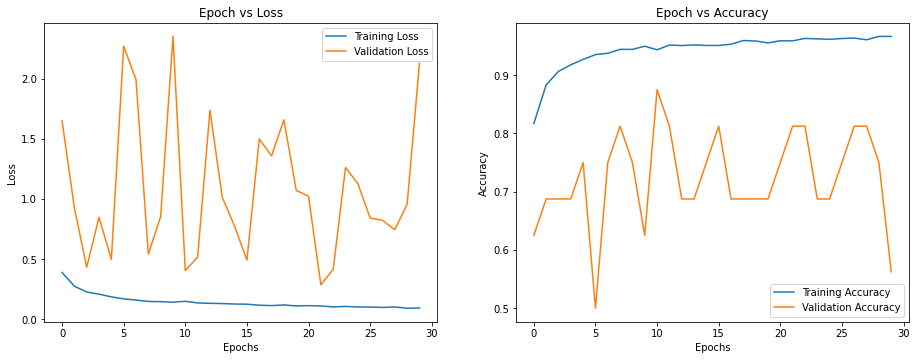

In [15]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

In [ ]:
test(net, device, test_loader)